In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
import re
import json
from scipy.spatial import KDTree
from easyric import caas_lite
import tifffile as tf
from skimage.transform import ProjectiveTransform

In [14]:
import random
from tqdm.notebook import tqdm

In [4]:
shp_file = r"Y:\hwang_Pro\data\2020_tanashi_broccoli\02_GIS\rotate_grids\split_grid_2.5m.shp"
#shp_file = r"Y:\hwang_Pro\data\2021_tanashi_broccoli\02_GIS\split_grid.shp"

process_area = shp.read_shp2d(shp_file, name_field="id")
process_area.keys()

[io][shp][fields] Shp fields: {'id': 0, 'left': 1, 'top': 2, 'right': 3, 'bottom': 4}
[io][shp][proj] find ESRI projection file Y:\hwang_Pro\data\2020_tanashi_broccoli\02_GIS\rotate_grids\split_grid_2.5m.prj, and successfully obtain projection cartesian


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [5]:
root = f"Y:/hwang_Pro/data/2020_tanashi_broccoli/10_locate_by_cv/color_label_0417_mavic/keep_points_manual.shp"
points = shp.read_shp2d(root, name_field="name")

[io][shp][fields] Shp fields: {'name': 0}
[io][shp][proj] could not find ESRI projection file Y:/hwang_Pro/data/2020_tanashi_broccoli/10_locate_by_cv/color_label_0417_mavic/keep_points_manual.prj, could not operate auto-convention, Please convert projection system manually.


In [6]:
id_list = []
points_np = np.zeros((0,2))
for k, p in points.items():
    id_list.append(int(k))
    points_np = np.vstack([points_np, p])

In [7]:
kdtree = KDTree(points_np)

# Prepare pix4d project data

In [12]:
todo_pool = ["0520_p", "0522_p", "0525_p", "0526_p", "0528_p"]
date_dict = {}
for tp in todo_pool:
    p2 = Paths(tp)
    p4d = Pix4D(project_path=p2.pix4d_project, 
                raw_img_path=p2.raw_img, 
                project_name=p2.project_name,
                param_folder=p2.pix4d_param)
    
    before_project = pd.read_csv(f"{p2.root}/13_roi_on_raw/{p2.project_name}.csv")
    
    date_dict[f"20{tp[0:4]}"] = {"p2":p2, "p4d":p4d, "bp":before_project}

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200520_P4M_10m_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200520_P4M_10m_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200520_P4M_10m_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200522_P4M_10m_after_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200522_P4M_10m_after_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm give

In [9]:
def read_json(json_path):
    container = []
    with open(json_path, "r", encoding="utf-8") as f:
        js = json.loads(f.read())
        for item in js["shapes"]:
            points = np.asarray(item["points"])
            points = np.append(points, points[0,:][None,:], axis=0)
            container.append(points)
    return container


def json_name(date, roi_id, file_name):
    return f"labeled_v0_{date}_{roi_id}_{file_name[:-4]}.json"


def mk_rm_line(bound_np, rm_bound_id):
    bound_np = bound_np[:-1, :]
    
    return shapely.geometry.LineString(bound_np[rm_bound_id-1:rm_bound_id+2,:])


def get_grid_roi_info(df_csv, id, image_name):
    filtered = df_csv[(df_csv.id == id) & (df_csv.image == image_name)]
    roi_str = filtered.roi.values[0]
    roi_str = roi_str.replace("\n ", ",")
    roi_str = re.sub("\s+", ",", roi_str)
    roi_np = np.asarray(eval(roi_str))
    off_x = filtered.offset_x.values[0]
    off_y = filtered.offset_y.values[0]
    
    return roi_np, off_x, off_y

def find_polygon_center(poly):
    xmin, ymin  = poly.min(axis=0)
    xmax, ymax  = poly.max(axis=0)
    
    xctr = (xmin + xmax) / 2
    yctr = (ymin + ymax) / 2
    
    return np.asarray([xctr, yctr])

In [10]:
json_folder = r"Y:\hwang_Pro\data\2020_tanashi_broccoli\13_roi_on_raw\pred"
json_files = os.listdir(json_folder)

In [13]:
total_result = {}
div_thresh = 0.20 # m

for js_file in tqdm(json_files):
    js_path = os.path.join(json_folder, js_file)
    
    _, date, plot_id, _, photo = js_file[:-5].split("_")
    date = date[2:]
    photo = f"DJI_{photo}.JPG"
    
    p2 = date_dict[date]["p2"]
    p4d = date_dict[date]["p4d"]
    before_project = date_dict[date]["bp"]
    
    if date not in total_result.keys():
        total_result[date] = {}
    
    roi_np, off_x, off_y = get_grid_roi_info(before_project, int(plot_id), photo)
    detect_poly = read_json(js_path)
    
    # correct json offsets
    detect_poly_correct = []
    for roi in detect_poly:
        # correct by distortion
        roi_off = roi + np.asarray([off_x, off_y])
        detect_poly_correct.append(roi_off)
    
    # filter in broccolis
    grid_poly = shapely.geometry.Polygon(roi_np)
    rm_line = mk_rm_line(roi_np, 2)
    
    shapely_detect_in = []
    shapely_detect_out = []
    for i, roi in enumerate(detect_poly_correct):
        roi_spy = shapely.geometry.Polygon(roi)
        if roi_spy.intersects(rm_line):
            shapely_detect_out.append(i)
        else:
            if roi_spy.intersects(grid_poly):
                shapely_detect_in.append(i)
            else:
                shapely_detect_out.append(i)
                
    # reverse to dom coords
    pt = ProjectiveTransform()
    pt.estimate(process_area[plot_id] - p4d.offset.np[0:2], roi_np)
    
    ## crop dom to small parts 
    new_coord = geotiff.geo2pixel(process_area[plot_id], geo_head=p4d.dom_header)
    cropped, np_off, offset = geotiff.crop_by_coord(p4d.dom_file, new_coord, buffer=20)
    plt.imshow(cropped)
    
    new = new_coord - offset
    plt.plot(*new.T, 'b--')
    
    save_img = False
    for idx in shapely_detect_in:
        inv_np = pt.inverse(detect_poly_correct[idx])
        
        inv_np_geo = inv_np + p4d.offset.np[0:2]
        
        
        dist, id_list_idx = kdtree.query(find_polygon_center(inv_np_geo))
        broccoli_id = id_list[id_list_idx]
        
        if dist > div_thresh:
            color = "g"
            print(f"Broccoli {broccoli_id} detect distence {dist} is over {div_thresh}")
            save_img = True
        else:
            color = "r"
            
        if broccoli_id in total_result[date].keys():
            total_result[date][broccoli_id].append(inv_np_geo)
        else:
            total_result[date][broccoli_id] = [inv_np_geo]
                
        # plot
        inv_np_dom = geotiff.geo2pixel(inv_np_geo, geo_head=p4d.dom_header) - offset
        plt.plot(*inv_np_dom.T, f"{color}-")
        plt.gcf().set_size_inches((16, 16))
        
    # decide which to save
    if random.randint(0, 10) == 5 or save_img:
        plt.savefig(f"Y:/hwang_Pro/data/2020_tanashi_broccoli/20_results/01_project_on_dom/{save_img}_{date}_{plot_id}.png")
    plt.clf()

  5%|████▎                                                                           | 91/1680 [03:11<26:39,  1.01s/it]

Broccoli 1957 detect distence 0.20937959722390304 is over 0.2


  8%|██████                                                                         | 130/1680 [03:51<28:14,  1.09s/it]

Broccoli 2951 detect distence 0.20883738136010466 is over 0.2


 16%|████████████▊                                                                  | 272/1680 [06:23<21:38,  1.08it/s]

Broccoli 6252 detect distence 0.20851241743098117 is over 0.2


 35%|███████████████████████████▋                                                   | 589/1680 [11:20<12:41,  1.43it/s]

Broccoli 5674 detect distence 0.21379570013119573 is over 0.2


 36%|████████████████████████████▍                                                  | 604/1680 [11:31<12:06,  1.48it/s]

Broccoli 5772 detect distence 0.21184998360540783 is over 0.2


 40%|███████████████████████████████▎                                               | 667/1680 [12:13<10:09,  1.66it/s]

Broccoli 7366 detect distence 0.24503831041757276 is over 0.2


 41%|████████████████████████████████▎                                              | 687/1680 [13:03<46:35,  2.82s/it]

Broccoli 129 detect distence 0.20481153797070414 is over 0.2


 42%|████████████████████████████████▉                                              | 701/1680 [13:28<13:44,  1.19it/s]

Broccoli 786 detect distence 0.2581533151203782 is over 0.2


 71%|███████████████████████████████████████████████████████▎                      | 1192/1680 [20:23<05:38,  1.44it/s]

Broccoli 3910 detect distence 0.23746795972452073 is over 0.2


 77%|████████████████████████████████████████████████████████████▏                 | 1296/1680 [21:41<04:27,  1.43it/s]

Broccoli 6219 detect distence 0.22192485618737448 is over 0.2


 78%|████████████████████████████████████████████████████████████▋                 | 1307/1680 [21:51<05:30,  1.13it/s]

Broccoli 7030 detect distence 0.2040934825902491 is over 0.2


 91%|██████████████████████████████████████████████████████████████████████▉       | 1527/1680 [25:48<01:44,  1.47it/s]

Broccoli 3910 detect distence 0.23420383394858296 is over 0.2


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [27:50<00:00,  1.01it/s]


<Figure size 1152x1152 with 0 Axes>

In [18]:
import pickle

with open('out/total_result20.pickle', 'wb') as handle:
    pickle.dump(total_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('out/total_result20.pickle', 'rb') as handle:
#    b = pickle.load(handle)

# region props

In [23]:
from PIL import Image, ImageDraw
from skimage.measure import label, regionprops, regionprops_table

In [100]:
def draw_binary_image(poly_list):
    poly_merge = np.vstack(poly_list)
    
    xmax, ymax = np.max(poly_merge, axis=0)
    xmin, ymin = np.min(poly_merge, axis=0)
    xlen = xmax - xmin
    ylen = ymax - ymin

    res = 0.001 # 1mm/ pix
    
    w = xlen / res
    h = ylen / res

    im = Image.new(mode='1', size=tuple(np.ceil([w, h]).astype(int)))
    draw = ImageDraw.Draw(im)
    
    points = []
    for p in poly_list:
        point = (p - np.asarray([xmin, ymin])) / res
        draw.polygon(point.reshape(len(point)*2).tolist(), fill='white', outline='white')
        points.append(point)
        
    return np.asarray(im), points

def remove_outlier_poly(poly_list, broccoli_id, points):
    
    center = points[str(broccoli_id)]
    
    dist_list = []
    area_list = []
    for poly in poly_list:
        pc = find_polygon_center(poly)
        dist = calc_dist(pc, center[0, :])
        dist_list.append(dist)
        
        xmin, ymin = np.min(poly, axis=0)
        poly_area = poly - np.asarray([xmin, ymin])
        area = shapely.geometry.Polygon(poly_area * 100).area # cm2
        area_list.append(area)
        
    dist_np = np.asarray(dist_list)
    area_list = np.asarray(area_list)
    
    """
    dist_np_div = dist_np - dist_np.min()
    
    selected = dist_np_div < 0.15
    
    new_list = []
    for i, b in enumerate(selected):
        if b:
            new_list.append(poly_list[i])
            
    return new_list
    """
    return [poly_list[area_list.argmax()]]
    
    
def calc_dist(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [19]:
import cv2

In [101]:
props_all = pd.DataFrame(columns=["date", "label", "area", "convex_area", "eccentricity", "equivalent_diameter", "major_axis_length", "minor_axis_length", "min_area_rect_max", "min_area_rect_min", "perimeter", 'circularity'])

for date, v in tqdm(total_result.items(), desc="date"):
    
    for broccoli_id, poly_list in tqdm(v.items(), desc="id"):
        
        poly_num = len(poly_list)
        
        if poly_num == 1:
            binary_img, pix = draw_binary_image(poly_list)
            rect = cv2.minAreaRect(pix[0].astype(np.int32))
            label_img = label(binary_img)
        else:
            # draw plots
            fig, ax = plt.subplots(1,2, dpi=300)
            
            p4d = date_dict[date]["p4d"]
            
            new_coord = geotiff.geo2pixel(np.vstack(poly_list), geo_head=p4d.dom_header)
            cropped, np_off, offset = geotiff.crop_by_coord(p4d.dom_file, new_coord, buffer=20)
            ax[0].imshow(cropped)
            
            for p in poly_list:
                pix = geotiff.geo2pixel(p, geo_head=p4d.dom_header) - offset
                ax[0].plot(*pix.T, 'r-', alpha=0.3)
                
            center = points[str(broccoli_id)]
            center_pix = geotiff.geo2pixel(center, geo_head=p4d.dom_header) - offset
            ax[0].plot(center_pix[0, 0], center_pix[0, 1], 'ro')
            
            # judge if noise -> clean poly_list
            poly_list = remove_outlier_poly(poly_list, broccoli_id, points)
            binary_img, pix = draw_binary_image(poly_list)
            
            rect = cv2.minAreaRect(pix[0].astype(np.int32))

            for p in poly_list:
                pixel_pos = geotiff.geo2pixel(p, geo_head=p4d.dom_header) - offset
                ax[0].plot(*pixel_pos.T, 'r-', alpha=0.7)
            
            ax[1].imshow(binary_img, cmap="gray")
            ax[1].invert_yaxis()
            
            ax[1].plot(*pix[0].T, 'r--')

            box = cv2.boxPoints(rect)
            box = np.append(box, box[0,:][None,:], axis = 0)
            ax[1].plot(*box.T)
            
            if len(pix) != 1:
                print(pix, len(pix))
                raise ValueError("Not equal to 1")
                
            
            label_img = label(binary_img)
            regions = regionprops(label_img)
            for props in regions:
                y0, x0 = props.centroid

                orientation = props.orientation
                x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
                y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
                x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
                y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length


                ax[1].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
                ax[1].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
                ax[1].plot(x0, y0, '.g', markersize=15)
                
            
            plt.savefig(f"Y:/hwang_Pro/data/2020_tanashi_broccoli/20_results/02_fix_wrong/{date}_{broccoli_id}.png")
            plt.close(fig)
            
        
        props = pd.DataFrame(regionprops_table(label_img, properties=["area", "convex_area", "eccentricity", "equivalent_diameter", "major_axis_length", "minor_axis_length", "perimeter"]))
        props['circularity'] = 4 * props.area * np.pi / props.perimeter ** 2
        props['date'] = f"20{date}"
        props['label'] = broccoli_id
        
        props["min_area_rect_max"] = max(rect[1][0], rect[1][1])
        props["min_area_rect_min"] = min(rect[1][0], rect[1][1])
        props = props[["date", "label", "area", "convex_area", "eccentricity", "equivalent_diameter", "major_axis_length", "minor_axis_length", "min_area_rect_max", "min_area_rect_min", "perimeter", 'circularity']]
        
        props_all.loc[len(props_all)] = props.iloc[0]

date:   0%|          | 0/5 [00:00<?, ?it/s]

id:   0%|          | 0/7276 [00:00<?, ?it/s]

id:   0%|          | 0/7157 [00:00<?, ?it/s]

id:   0%|          | 0/7169 [00:00<?, ?it/s]

id:   0%|          | 0/7076 [00:00<?, ?it/s]

id:   0%|          | 0/7068 [00:00<?, ?it/s]

In [68]:
pix[0].astype(np.int32)

array([[14,  1],
       [11,  0],
       [ 1,  4],
       [ 0, 10],
       [ 8, 45],
       [13, 52],
       [17, 54],
       [32, 44],
       [36, 33],
       [31, 17],
       [25, 15],
       [14,  1],
       [14,  1]])

In [69]:
regions = regionprops(label_img)

In [49]:
import math

In [72]:
rect = cv2.minAreaRect(pix[0].astype(np.int32))
box = cv2.boxPoints(rect)
box

array([[-4.5444837,  4.8576508],
       [24.380781 , -4.1814957],
       [40.288258 , 46.72242  ],
       [11.362993 , 55.761566 ]], dtype=float32)

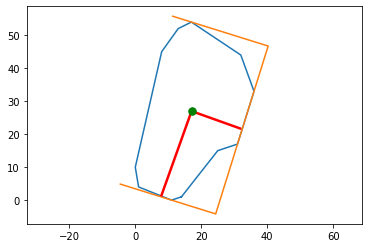

In [73]:
plt.plot(*pix[0].astype(np.int32).T)

box = cv2.boxPoints(rect)
plt.plot(*box.T)
plt.axis("equal")

for props in regions:
    y0, x0 = props.centroid
    
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    

    plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    plt.plot(x0, y0, '.g', markersize=15)

In [75]:
print(props.minor_axis_length, props.major_axis_length)

31.240005186735427 54.1295443882743


In [77]:
print(rect[1])

(53.33156967163086, 30.304738998413086)


In [106]:
props_all

,date,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity
0,20200520,292,1276,1344,0.816649,40.306993,54.129544,31.240005,53.331570,30.304739,148.953319,0.722704
1,20200520,1,3606,3709,0.519565,67.759145,73.503186,62.803382,69.652748,65.997498,231.722871,0.843913
2,20200520,148,4273,4434,0.678919,73.760102,87.082156,63.936849,82.405136,66.740005,265.421356,0.762204
3,20200520,293,5143,5282,0.449899,80.921388,85.785056,76.612857,83.176819,76.316864,279.906638,0.824898
4,20200520,2,4276,4490,0.520682,73.785990,80.426928,68.664528,77.712067,69.247444,263.036580,0.776632
...,...,...,...,...,...,...,...,...,...,...,...,...
35741,20200528,7546,17715,18221,0.501960,150.184681,161.953955,140.072502,159.028656,141.719421,517.872150,0.830053
35742,20200528,7116,19232,21152,0.509643,156.483044,171.425192,147.491877,169.115128,156.980820,589.126984,0.696332
35743,20200528,7406,17105,18040,0.639508,147.576294,169.656371,130.429146,163.861603,131.679733,538.901587,0.740140
35744,20200528,7262,14412,15958,0.695328,135.461907,163.834892,117.746931,162.350967,119.264641,516.073160,0.680004


In [110]:
props_all = props_all.astype({"date": int})

In [112]:
props_all.to_excel("out/2021_measured_fix.xlsx")

# link to field_measure

In [104]:
link_table = pd.read_csv("out/non_destructive20.csv")
link_table

,date,Ground_ID,UAV_ID,flower_size_max
0,20200522,S20_01,2916,77
1,20200522,S20_02,2915,153
2,20200522,S20_03,2914,124
3,20200522,S20_04,2913,102
4,20200522,S20_05,2912,103
...,...,...,...,...
355,20200528,N25_26,3548,157
356,20200528,N25_27,3547,168
357,20200528,N25_28,3546,166
358,20200528,N25_29,3545,146


In [111]:
merged_pd = pd.merge(props_all, link_table, left_on=["date", "label"], right_on=["date", "UAV_ID"])
merged_pd

,date,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity,Ground_ID,UAV_ID,flower_size_max
0,20200522,2815,9040,9629,0.789613,107.285066,141.287568,86.694770,136.758377,91.151993,400.617316,0.707814,N20_30,2815,131
1,20200522,2816,12157,12694,0.632702,124.413718,142.835094,110.610777,138.253326,115.262581,440.717821,0.786530,N20_29,2816,130
2,20200522,2817,8064,9785,0.706411,101.328198,133.284799,94.339247,128.514725,97.051231,429.759451,0.548668,N20_28,2817,109
3,20200522,2818,11077,12338,0.726258,118.758892,147.070639,101.099568,141.267517,102.744728,469.303607,0.632010,N20_27,2818,143
4,20200522,2827,11978,12648,0.728131,123.494386,150.504740,103.161644,145.275421,105.871941,447.788889,0.750667,N20_18,2827,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,20200528,3642,22832,23632,0.496955,170.501042,183.758068,159.460846,178.484558,166.459473,597.712770,0.803098,S25_05,3642,171
354,20200528,3643,19597,20709,0.331038,157.960993,164.168401,154.912143,160.859299,159.415680,570.150324,0.757566,S25_04,3643,162
355,20200528,3644,13382,16270,0.873109,130.531573,200.760852,97.875911,189.000305,108.115051,566.156421,0.524636,S25_03,3644,173
356,20200528,3645,20596,22777,0.675346,161.937153,194.540305,143.473633,190.830292,153.818451,614.742207,0.684868,S25_02,3645,181


In [108]:
props_all.date

0        20200520
1        20200520
2        20200520
3        20200520
4        20200520
           ...   
35741    20200528
35742    20200528
35743    20200528
35744    20200528
35745    20200528
Name: date, Length: 35746, dtype: object